In [2]:
!pip3 install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.8 MB/s eta 0:00:00:00:01


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import Levenshtein


In [4]:
!ls /kaggle/input/

librispeech-datasets


In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Preprocessing Data

In [6]:

dataset_path = "/kaggle/input/librispeech-datasets/"
def download(dataset):
    audioset = torchaudio.datasets.LIBRISPEECH(dataset_path+'/'+dataset,url=dataset,download=False)
    return audioset

In [7]:
train_clean = download('train-clean-100')
dev_clean = download('dev-clean')
test_clean = download('test-clean')

In [8]:
class Unigram():
    def __init__(self,word_model_type):
        self.word_model_type = 'unigram'
        self.blank_id = 28
        self.n_class = 29

        self.SPACE = "[space]"
        self.characters = "' " + self.SPACE + " " +" ".join("abcdefghijklmnopqrstuvwxyz")
        self.tokens = self.characters.split(' ')

        self.char_to_id = {char: idx for idx, char in enumerate(self.tokens)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.tokens)}

    def text_to_int(self, sentence: str):
        idx_sequence = []
        for ch in sentence:
            idx = self.char_to_id[self.SPACE] if ch == " " else self.char_to_id[ch]
            idx_sequence.append(idx)
        return idx_sequence

    def int_to_text(self, indices):
        sentence = []
        for i in indices:
            ch = self.id_to_char[i]
            sentence.append(ch)
        return "".join(sentence).replace(self.SPACE, " ")


word_encoding_model = Unigram('unigram')
original = "my name is olan"
encoded = word_encoding_model.text_to_int(original)
reconstructed = word_encoding_model.int_to_text(encoded)
print(original)
print(encoded)
print(reconstructed)

my name is olan
[14, 26, 1, 15, 2, 14, 6, 1, 10, 20, 1, 16, 13, 2, 15]
my name is olan


In [9]:
def preprocess(audioset,split,stride,word_model):

        if split[:5] == "train":
            train_pipe = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35))
            augment_fn = train_pipe
        else:
            test_pipe = torchaudio.transforms.MelSpectrogram()
            augment_fn = test_pipe
      
        spectrograms = []
        indices = []
        len_spectrograms = []
        len_indices = []
        
        for waveform, _, transcript, _, _, _ in audioset:
            # Augment audio data
            spec = augment_fn(waveform).squeeze(0).transpose(0,1)
            spectrograms.append(spec)

            # Convert text transcript to sequence of ids
            ids = torch.Tensor(word_model.text_to_int(transcript.lower()))
            indices.append(ids)

            # Append audio and text length
            if stride == 2:
                len_spec = spec.shape[0]//stride
            else:
                len_spec = spec.shape[0]//stride - 2
            
            len_spectrograms.append(len_spec)
            len_indices.append(len(ids))
        
        # Zero pad
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        indices = nn.utils.rnn.pad_sequence(indices, batch_first=True)

        return spectrograms, indices, len_spectrograms, len_indices

In [10]:
def reading_data_sample(loader):
    print("Data length : ",len(loader.dataset))
    for batch_sample in loader:
        print("Spectrogram shape:", list(batch_sample[0].shape))
        print("Label shape:", list(batch_sample[1].shape))
        print("Mel length (length of each spectrogram):", batch_sample[2][:6], "...")
        print("Idx length (length of each label):", batch_sample[3][:6], "...")
        break

In [11]:
#Best HP combination
batch_size = 16
epochs = 10
n_features = 128 
stride = 2      
lr = 0.0005


In [12]:
train_loader  = DataLoader(dataset=train_clean,
                               batch_size=batch_size,
                               shuffle=False,
                               collate_fn=lambda x: preprocess(x, "train-clean-100", stride, word_encoding_model))


dev_clean_loader = DataLoader(dataset=dev_clean,
                               batch_size=batch_size,
                               shuffle=False,
                               collate_fn=lambda x: preprocess(x, "dev-clean", stride, word_encoding_model))


test_clean_loader = DataLoader(dataset=test_clean,
                               batch_size=batch_size,
                               shuffle=False,
                               collate_fn=lambda x: preprocess(x, "test-clean", stride, word_encoding_model))

In [13]:
print(f"Train : {len(train_loader.dataset)} samples ")
print(f"Dev Clean : {len(dev_clean_loader.dataset)} samples ")
print(f"Test Clean : {len(test_clean_loader.dataset)} samples ")
print()

reading_data_sample(train_loader)

Train : 28539 samples 
Dev Clean : 2703 samples 
Test Clean : 2620 samples 

Data length :  28539
Spectrogram shape: [16, 1, 128, 1276]
Label shape: [16, 283]
Mel length (length of each spectrogram): [563, 638, 558, 588, 501, 607] ...
Idx length (length of each label): [201, 283, 250, 268, 227, 263] ...


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [14]:
# The time dimension keeps varying so i am normalising on the fixed feature dimension
class LayerNorm(nn.Module):
    def __init__(self, n_features):
        super(LayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_features)
    
    def forward(self, x):
        # x is of the form [batch,channels,n_features,time]
        x = x.transpose(2, 3).contiguous()
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()



class ResNetInv(nn.Module):
    def __init__(self, in_channels, out_channels, n_features, kernel, stride, drop_rate):
        super(ResNetInv, self).__init__()

        self.cnn_1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=1)
        self.cnn_2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=1)
        
        self.dropout_1 = nn.Dropout(drop_rate)
        self.dropout_2 = nn.Dropout(drop_rate)
        
        self.layer_norm_1 = LayerNorm(n_features)
        self.layer_norm_2 = LayerNorm(n_features)

    
    def forward(self, x):
        skip = x

        # 1st stage
        x = self.layer_norm_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.cnn_1(x)

        # 2nd stage
        x = self.layer_norm_2(x)
        x = F.relu(x)
        x = self.dropout_2(x)
        x = self.cnn_2(x)
    
        x += skip
        return x


class BiGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, drop_rate, batch_first):
        super(BiGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(drop_rate)
    
    def forward(self, x):
        """
        Input shape: [batch, seq_len, n_features]
        """
        x = self.layer_norm(x)
        x = F.relu(x)
        x, _ = self.gru(x)
        x = self.dropout(x)
        return x


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, drop_rate):
        super(Classifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [15]:
# First model architecture for this ASR project - A variation of the DeepSpeech Model
class CustomModel1(nn.Module):
    
    def __init__(self, n_cnn, n_rnn, rnn_dim, n_features, n_class, stride=2, drop_rate=0.2):
        super(CustomModel1, self).__init__()
        n_features = n_features // 2

        # init conv2d layer
        self.init_cnn = nn.Conv2d(1, 32, 3, stride=(2,stride), padding=1)

        # 1st stage: ResNet blocks
        self.stage_1 = nn.Sequential(
            *[ResNetInv(32, 32, n_features=n_features, kernel=3, stride=1, drop_rate=drop_rate) 
              for _ in range(n_cnn)])

        # linear adapter
        self.fc_adapter = nn.Linear(n_features*32, rnn_dim)

        # bi-rnn layers
        self.stage_2 = nn.Sequential(
            *[BiGRU(rnn_dim=rnn_dim if layer==0 else rnn_dim*2, 
                    hidden_size=rnn_dim, 
                    drop_rate=drop_rate, 
                    batch_first=True)
            for layer in range(n_rnn)])

        # linear classifier
        self.classifier = Classifier(rnn_dim*2, rnn_dim, n_class, drop_rate)

    def forward(self, x):
        x = self.init_cnn(x)

        # Inverse Resnet
        x = self.stage_1(x)

        # linear adapter
        shape = x.shape
        x = x.view(shape[0], shape[1]*shape[2], shape[3]) # (batch, features, time)
        x = x.transpose(1, 2) # (batch, time, features)
        x = self.fc_adapter(x)

        # Bi-GRU
        x = self.stage_2(x)

        # Classifier
        x = self.classifier(x)

        return x

In [16]:
cm1 = CustomModel1(n_cnn=3,
                             n_rnn=5, 
                             rnn_dim=512, 
                             n_features=n_features, 
                             n_class=word_encoding_model.n_class,
                             stride=stride,
                             drop_rate=0.2).to(device)

tot_params = sum([p.numel() for p in cm1.parameters()])
model_name="custom model 1"
print(f"Number of parameters: {tot_params}")

Number of parameters: 23705373


In [17]:
model_to_train = cm1
adamW = optim.AdamW(model_to_train.parameters(), lr)
ctc_loss = nn.CTCLoss(blank=word_encoding_model.blank_id).to(device)
one_cycle_lr = optim.lr_scheduler.OneCycleLR(adamW,
                                             max_lr=lr,
                                             steps_per_epoch=int(len(train_loader)),
                                             epochs=epochs,
                                             anneal_strategy="linear")

In [18]:
def train(epoch, dataset_loader, model, optimizer, scheduler, fn_loss):
    print(f"Traininig... (e={epoch})")
    
    # Train mode ON
    model.train()
    total_train_loss = 0  #tracking loss
    n_samples = int(len(dataset_loader.dataset))

    for idx, audio_data in enumerate(dataset_loader):
        
        # Get audio data with shape [batch, 1, n_features, seq_len]
        spectrograms, indices, len_spectrograms, len_indices = audio_data
        spectrograms, indices = spectrograms.to(device), indices.to(device)

        optimizer.zero_grad()

        # Forward pass
        out = model(spectrograms)
        out = F.log_softmax(out, dim=2)
        out = out.transpose(0, 1)
        
        # Backward pass
        loss = fn_loss(out, indices, len_spectrograms, len_indices)
        loss.backward()

        # Step
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        

        # Log
        if idx % 20 == 0 or idx == n_samples:
            print("Epoch: {}, [{}/{}], Loss: {:.6f}".format(
                epoch, 
                idx*len(spectrograms), 
                n_samples,
                loss.item()))

    avg_train_loss = total_train_loss/n_samples
    return avg_train_loss
    

In [19]:
# Computes Word Error Rate
def compute_wer(hypothesis, reference):
    hypothesis_words = hypothesis.split()
    reference_words = reference.split()
    
    wer = Levenshtein.distance(hypothesis_words, reference_words) / len(reference_words)
    return wer

# Computes Character Error Rate
def compute_cer(hypothesis, reference):

    cer = Levenshtein.distance(hypothesis, reference) / len(reference)
    return cer

#     Calculates CER for each hyp-ref pair, and returns the average
def avg_cer(batch_hyp, batch_ref):
    batch_size = len(batch_ref)
    out = []
    for i in range(batch_size):
        out.append(compute_cer(batch_hyp[i], batch_ref[i]))
    
    return sum(out) / batch_size

#     Calculates WER for each hyp-ref pair, and returns the average
def avg_wer(batch_hyp, batch_ref):
    batch_size = len(batch_ref)
    out = []
    for i in range(batch_size):
        out.append(compute_wer(batch_hyp[i], batch_ref[i]))
    
    return sum(out) / batch_size

In [20]:
def decode_prob(prob, word_encoding_model):
    """
    Decodes (a batch of) log-probabilities
    into characters.
    prob -> shape (e.g.) [16, 650, 29]
    """
    prob = torch.transpose(prob, 0, 1)
    arg_maxes = torch.argmax(prob, dim=-1) # [16, 650]
    decodes = []

    for i, args in enumerate(arg_maxes):
        decode = []
        for j, index in enumerate(args):
             # ignore blank id
            if index == word_encoding_model.blank_id:
                continue
            # avoid repetitions
            if j != 0 and index == args[j-1]:
                continue
            decode.append(index.item())
        decodes.append(word_encoding_model.int_to_text(decode))
    return decodes


def decode_labels(indices, len_indices, word_encoding_model):
    """
    Decodes (a batch of) ids into characters.
    indices -> shape: [32, 300]
    len_indices -> shape: [32]
    word_model -> tool to convert idx into chars
    """
    out = []
    for i, ids in enumerate(indices):
        len_ids = len_indices[i]
        unpad_ids = ids[:len_ids]
        out.append(word_encoding_model.int_to_text(unpad_ids.tolist()))
    return out

In [21]:
def test(epoch, dataset_name, dataset_loader, model, optimizer, fn_loss, debug=False):
    print(f"Testing on {dataset_name} (epoch={epoch})")
    model.eval()

    total_loss = 0
    wer_list = []
    cer_list = []

    n_batch = int(len(dataset_loader))

    with torch.no_grad():
        for idx, audio_data in enumerate(dataset_loader):
        
            # Get audio data
            spectrograms, indices, len_spectrograms, len_indices = audio_data
            spectrograms, indices = spectrograms.to(device), indices.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            out = model(spectrograms)
            out = F.log_softmax(out, dim=2)
            out = out.transpose(0, 1)

            # Compute loss
            loss = fn_loss(out, indices, len_spectrograms, len_indices)
            total_loss += loss.item() / n_batch

            # Metrics
            decode_hypothesis = decode_prob(out, word_encoding_model)
            decode_reference = decode_labels(indices, len_indices, word_encoding_model)

            wer_list.append(avg_wer(decode_hypothesis, decode_reference))
            cer_list.append(avg_cer(decode_hypothesis, decode_reference))
            
            
    print(f"Loss: {total_loss:.6f}")
    print(f"WER: {sum(wer_list)/len(wer_list):.4f}")
    print(f"CER: {sum(cer_list)/len(cer_list):.4f}")

    avg_test_wer = sum(wer_list) / len(wer_list)
    avg_test_cer = sum(cer_list) / len(cer_list)

    return total_loss, avg_test_wer, avg_test_cer

In [22]:
import time

train_loss = []
# dev_loss = []
# dev_wer = []
# dev_cer = []

total_training_time = 0 

for epoch in range(1, epochs+1):
    #calculate train time
    training_start = time.time()
    
    train_epoch_loss = train(epoch, train_loader, model_to_train, adamW, one_cycle_lr, ctc_loss)

    training_end = time.time()

    training_time = (training_end - training_start)/60  #measuring in mins
    total_training_time += training_time
    
    print(f"Epoch {epoch} training time: {training_time:.2f} minutes")

    train_loss.append(train_epoch_loss)

    # #dev
    # dev_epoch_loss, dev_epoch_wer, dev_epoch_cer = test(epoch, "dev-clean", dev_clean_loader, model_to_train, adamW, ctc_loss)
    # dev_loss.append(dev_epoch_loss)
    # dev_wer.append(dev_epoch_wer)
    # dev_cer.append(dev_epoch_cer)


avg_training_time = total_training_time / epochs
print(f"\nTotal training time: {total_training_time:.2f} minutes")
print(f"\nAverage training time: {avg_training_time:.2f} minutes")

#Test set
test_epoch_loss, test_epoch_wer, test_epoch_cer = test(epoch, "test-clean", test_clean_loader, model_to_train, adamW, ctc_loss)
print(f"Test Loss: {test_epoch_loss:.4f}")
print(f"Test WER: {test_epoch_wer:.4f}")
print(f"Test CER: {test_epoch_cer:.4f}")


Traininig... (e=1)


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch: 1, [0/28539], Loss: 5.665479
Epoch: 1, [320/28539], Loss: 4.009433
Epoch: 1, [640/28539], Loss: 3.151609
Epoch: 1, [960/28539], Loss: 3.008581
Epoch: 1, [1280/28539], Loss: 2.922391
Epoch: 1, [1600/28539], Loss: 2.870008
Epoch: 1, [1920/28539], Loss: 3.157031
Epoch: 1, [2240/28539], Loss: 2.892590
Epoch: 1, [2560/28539], Loss: 2.871378
Epoch: 1, [2880/28539], Loss: 2.911410
Epoch: 1, [3200/28539], Loss: 2.860404
Epoch: 1, [3520/28539], Loss: 2.839425
Epoch: 1, [3840/28539], Loss: 2.867253
Epoch: 1, [4160/28539], Loss: 2.848605
Epoch: 1, [4480/28539], Loss: 2.887779
Epoch: 1, [4800/28539], Loss: 2.930635
Epoch: 1, [5120/28539], Loss: 2.884335
Epoch: 1, [5440/28539], Loss: 2.886437
Epoch: 1, [5760/28539], Loss: 2.828763
Epoch: 1, [6080/28539], Loss: 2.839197
Epoch: 1, [6400/28539], Loss: 2.834445
Epoch: 1, [6720/28539], Loss: 2.863348
Epoch: 1, [7040/28539], Loss: 2.907986
Epoch: 1, [7360/28539], Loss: 2.830158
Epoch: 1, [7680/28539], Loss: 2.876533
Epoch: 1, [8000/28539], Loss: 2

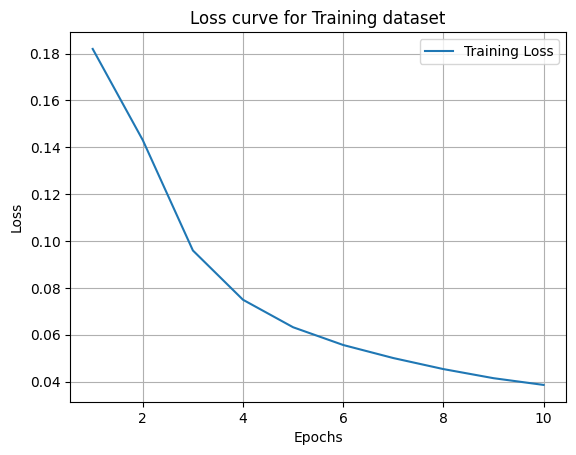

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve for Training dataset')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
torch.save(model_to_train.state_dict(), 'model_weights.pth')

torch.save({
    'epoch': epoch,
    'model_state_dict': model_to_train.state_dict(),
    'optimizer_state_dict': adamW.state_dict(),
    'loss': train_loss[-1],
    'test_loss': test_epoch_loss,
    'test_wer': test_epoch_wer,
    'test_cer': test_epoch_cer
}, 'model_results.pth')

print("\nModel saved successfully.")


Model saved successfully.
